In [0]:
from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [0]:
%pip install kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/82.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 81.9/82.7 kB 3.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/48/5d/acf5905c36149bbaec41ccf7f2b68814647347b72075ac0b1fe3022fdc73/tqdm-4.66.5-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/57.6 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for python-slugify from https://files.pythonhosted.org/packages/a4/62/02da182e544a51a5c3ccf4b03ab79df279f9c60c5e82d5e8bec7ca26ac11/python_slugify-8.0.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for bleach from https://files.pythonhosted.org/packages/ea/63/da7237

In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/FileStore/tables/kaggle.json'

In [0]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset



Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0%|                                               | 0.00/67.4k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 67.4k/67.4k [00:00<00:00, 280kB/s]


In [0]:
!unzip stroke-prediction-dataset.zip -d /tmp/stroke-prediction-dataset


Archive:  stroke-prediction-dataset.zip
  inflating: /tmp/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv  


In [0]:
# Copy the file from local tmp directory to DBFS
dbutils.fs.cp("file:/tmp/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv", "dbfs:/user/hive/warehouse/hive_metastore/default/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")


True

# Data Read And Data Cleansing

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
df = spark.read.csv(f"dbfs:/user/hive/warehouse/hive_metastore/default/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv", header=True, inferSchema=True)

In [0]:
df.show(5)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [0]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



Handeling null values


In [0]:
df= df.filter(df.bmi != "N/A")

4908

In [0]:
for i in df.columns:
  print(f"count of null values in column: {i}=",df.select(i).where(df[i].isNull()).count())


count of null values in column id 0
count of null values in column gender 0
count of null values in column age 0
count of null values in column hypertension 0
count of null values in column heart_disease 0
count of null values in column ever_married 0
count of null values in column work_type 0
count of null values in column Residence_type 0
count of null values in column avg_glucose_level 0
count of null values in column bmi 0
count of null values in column smoking_status 0
count of null values in column stroke 0


In [0]:
df=df.na.drop()

Dropping "Other" category from gender

In [0]:
df.groupBy("gender").agg(count("gender")).show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|Female|         2994|
| Other|            1|
|  Male|         2115|
+------+-------------+



In [0]:
df = df.where(df.gender !="Other")
df.groupBy("gender").agg(count("gender")).show()

+------+-------------+
|gender|count(gender)|
+------+-------------+
|Female|         2994|
|  Male|         2115|
+------+-------------+



Making sure There are no misstypes 

In [0]:
#Making sure data is consistent
df.groupBy("work_type").agg(count("work_type")).show()

+-------------+----------------+
|    work_type|count(work_type)|
+-------------+----------------+
| Never_worked|              22|
|Self-employed|             819|
|      Private|            2924|
|     children|             687|
|     Govt_job|             657|
+-------------+----------------+



In [0]:
df.groupBy("Residence_type").agg(count("Residence_type")).show()

+--------------+---------------------+
|Residence_type|count(Residence_type)|
+--------------+---------------------+
|         Urban|                 2596|
|         Rural|                 2513|
+--------------+---------------------+



In [0]:
df.groupBy("smoking_status").agg(count("smoking_status")).show()

+---------------+---------------------+
| smoking_status|count(smoking_status)|
+---------------+---------------------+
|         smokes|                  789|
|        Unknown|                 1544|
|   never smoked|                 1892|
|formerly smoked|                  884|
+---------------+---------------------+



Editing Columns dtypes


In [0]:
df= df.withColumn('avg_glucose_level', df.avg_glucose_level.cast("int"))
df = df.withColumn('age', df['age'].cast('int'))
df = df.withColumn('bmi', df['bmi'].cast('int'))


# **EDA**

### Stroke Rate, Hypertension and Heart Disease Rates

In [0]:
stroke_rate = (df.filter(df.stroke == 1).count() / df.count()) * 100
print("Stroke rate :",stroke_rate)
Hypertension_rate = (df.filter(df.hypertension==1).count() / df.count()) * 100
print("Hypertension rate :",Hypertension_rate)
Heart_Disease = (df.filter(df.heart_disease==1).count() / df.count()) * 100
print("Heart Disease rate :",Heart_Disease)

Stroke rate : 4.258353708231459
Hypertension rate : 9.189079054604726
Heart Disease rate : 4.951100244498777


### Gender Distribution:

In [0]:
gender_dis = df.groupBy('gender').count()
gender_dis.show()

+------+-----+
|gender|count|
+------+-----+
|Female| 2897|
|  Male| 2011|
+------+-----+



### Avg Age, Min Age, Max Age:

In [0]:
age_dis= df.select(avg("age").alias("Avg Age"),min("age").alias("min Age"), max("age").alias("max Age"))
age_dis.show()

+-----------------+-------+-------+
|          Avg Age|min Age|max Age|
+-----------------+-------+-------+
|42.85757946210269|      0|     82|
+-----------------+-------+-------+



AVG Glucose Level and BMI

In [0]:
avg_Glucose_BMI = df.select(avg('avg_glucose_level').alias('AVG Glucose Level'), avg('bmi').alias("AVG bmi"))
avg_Glucose_BMI.show()

+------------------+------------------+
| AVG Glucose Level|           AVG bmi|
+------------------+------------------+
|104.80827220863895|28.894559902200488|
+------------------+------------------+



people who had a Stroke by their residence type

In [0]:
residence_dist= df.groupBy(["Residence_type","Stroke"]).count()
residence_dist.show()

+--------------+------+-----+
|Residence_type|Stroke|count|
+--------------+------+-----+
|         Urban|     1|  109|
|         Rural|     1|  100|
|         Urban|     0| 2381|
|         Rural|     0| 2318|
+--------------+------+-----+



people who had a Stroke by their smoking history

In [0]:
smoking_dist= df.groupBy(["smoking_status","Stroke"]).count().sort("smoking_status")
smoking_dist.show()

+---------------+------+-----+
| smoking_status|Stroke|count|
+---------------+------+-----+
|        Unknown|     1|   29|
|        Unknown|     0| 1454|
|formerly smoked|     0|  779|
|formerly smoked|     1|   57|
|   never smoked|     1|   84|
|   never smoked|     0| 1768|
|         smokes|     1|   39|
|         smokes|     0|  698|
+---------------+------+-----+



In [0]:
marriage_dist= df.groupBy(["ever_married","Stroke"]).count().sort("ever_married")
marriage_dist.show()

+------------+------+-----+
|ever_married|Stroke|count|
+------------+------+-----+
|          No|     0| 1681|
|          No|     1|   23|
|         Yes|     0| 3018|
|         Yes|     1|  186|
+------------+------+-----+



In [0]:
print("Correlation between age and stroke =",df.corr("age", "stroke"))
print("Correlation between avg_glucose_level and stroke =",df.corr("avg_glucose_level", "stroke"))
print("Correlation between bmi and stroke =",df.corr("bmi", "stroke"))

Correlation between age and stroke = 0.23220312283033545
Correlation between avg_glucose_level and stroke = 0.13902386634687675
Correlation between bmi and stroke = 0.0424529070226096


# Visualization

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()


### 1)Age and Glucose Level Distribution:

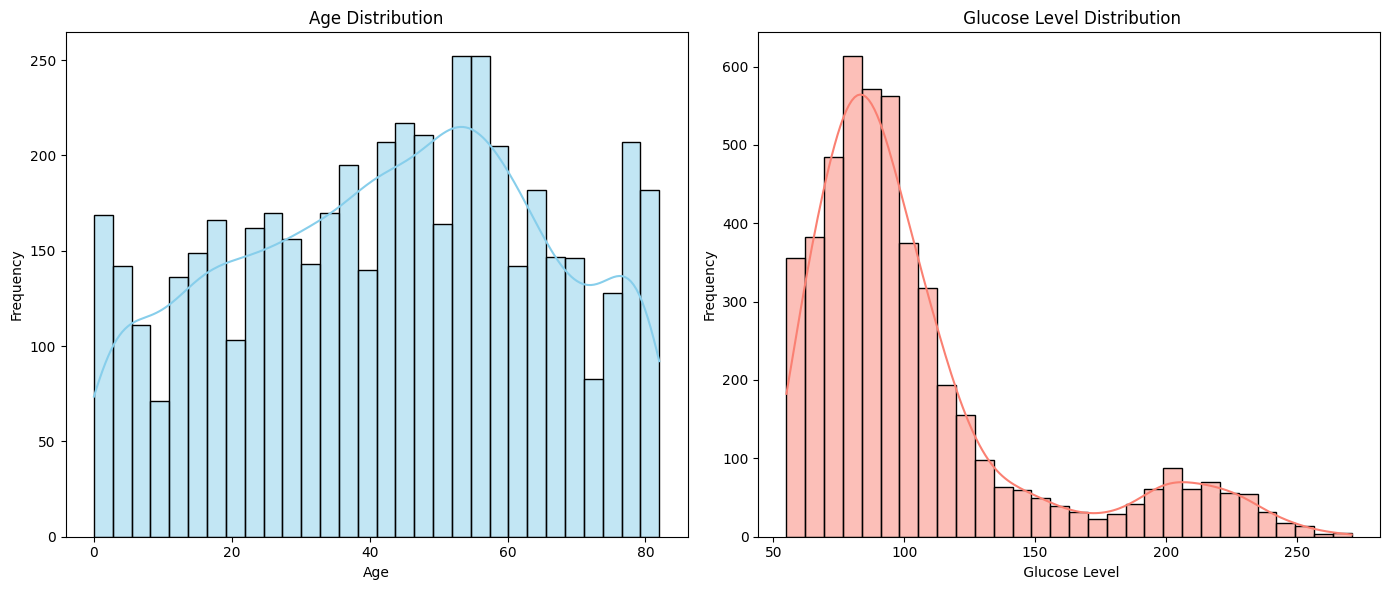

In [0]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(pandas_df['age'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(pandas_df['avg_glucose_level'], bins=30, kde=True, color='salmon')
plt.title(' Glucose Level Distribution')
plt.xlabel(' Glucose Level')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()



### 3)Stroke Rate By Different Labels 

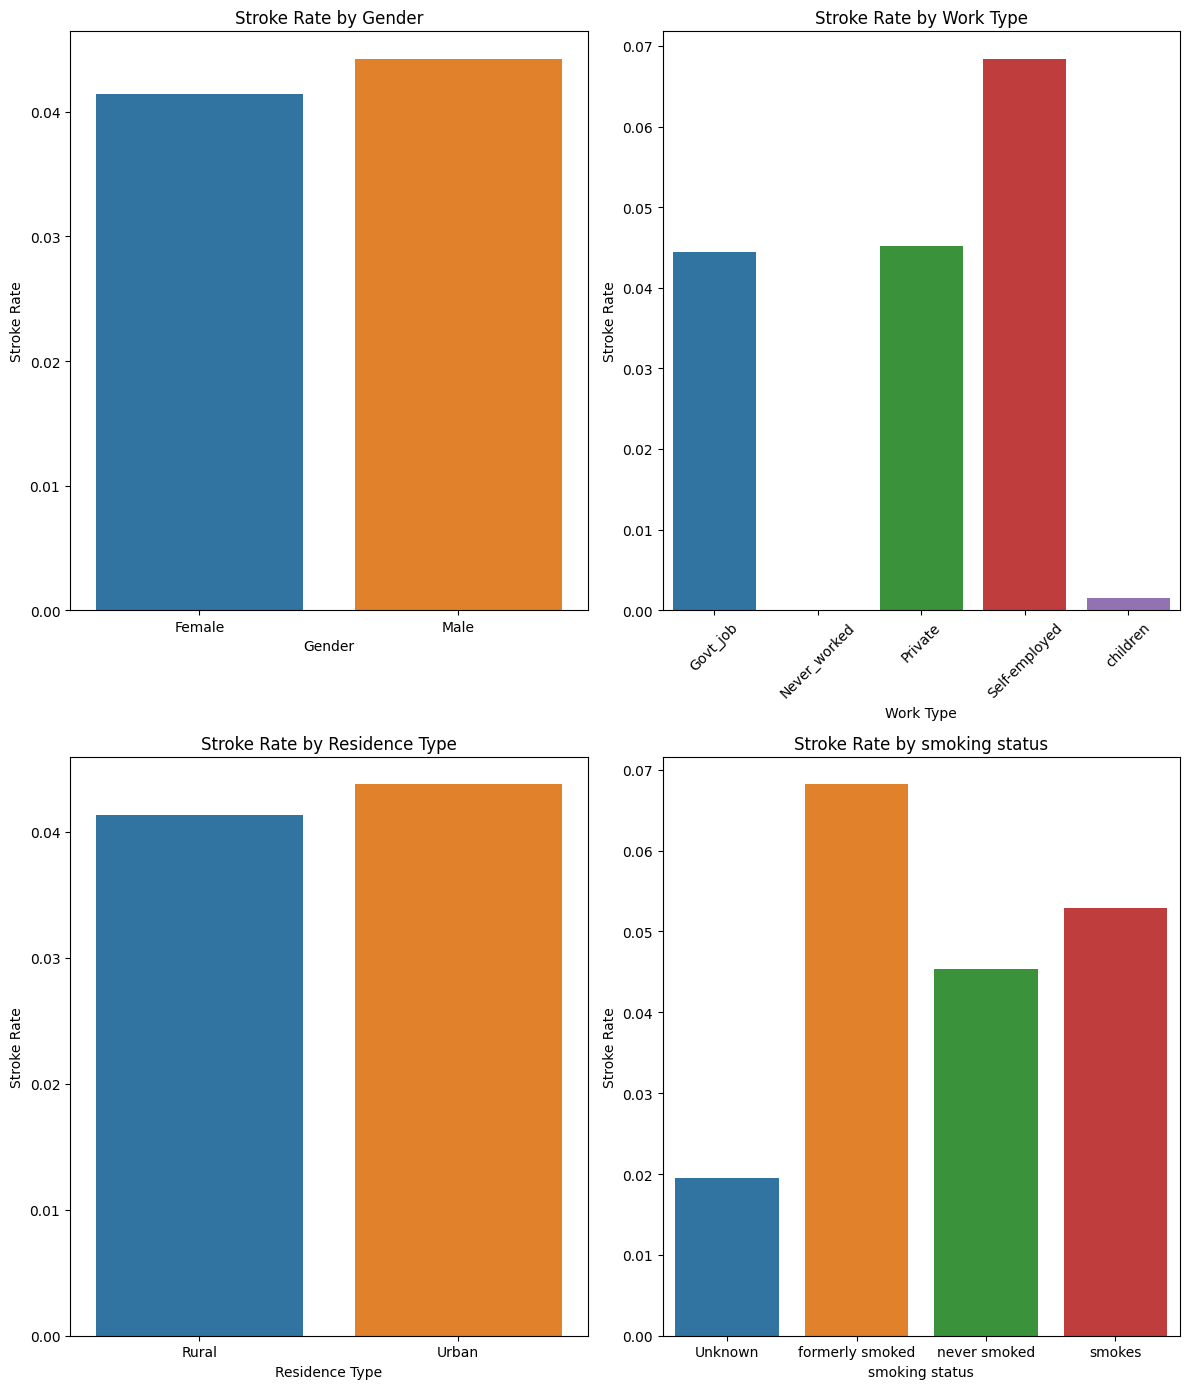

In [0]:

plt.figure(figsize=(12, 14))

# 1st subplot: Stroke Rate by Gender
plt.subplot(2, 2, 1)
gender_stroke = pandas_df.groupby('gender')['stroke'].mean().reset_index()
sns.barplot(x='gender', y='stroke', data=gender_stroke)
plt.title('Stroke Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Stroke Rate')

# 2nd subplot: Stroke Rate by Work Type
plt.subplot(2, 2, 2)
work_type_stroke = pandas_df.groupby('work_type')['stroke'].mean().reset_index()
sns.barplot(x='work_type', y='stroke', data=work_type_stroke)
plt.title('Stroke Rate by Work Type')
plt.xlabel('Work Type')
plt.ylabel('Stroke Rate')
plt.xticks(rotation=45)

# 3rd subplot: Stroke Rate by Residence Type
plt.subplot(2, 2, 3)
residence_stroke = pandas_df.groupby('Residence_type')['stroke'].mean().reset_index()
sns.barplot(x='Residence_type', y='stroke', data=residence_stroke)
plt.title('Stroke Rate by Residence Type')
plt.xlabel('Residence Type')
plt.ylabel('Stroke Rate')

plt.subplot(2, 2, 4)
smoking_stroke = pandas_df.groupby('smoking_status')['stroke'].mean().reset_index()
sns.barplot(x='smoking_status', y='stroke', data=smoking_stroke)
plt.title('Stroke Rate by smoking status')
plt.xlabel('smoking status')
plt.ylabel('Stroke Rate')
plt.tight_layout()

plt.show()




05:32 PM (<1s)
12
12
1
df.printSchema()
root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

### Smoking Status Distribution

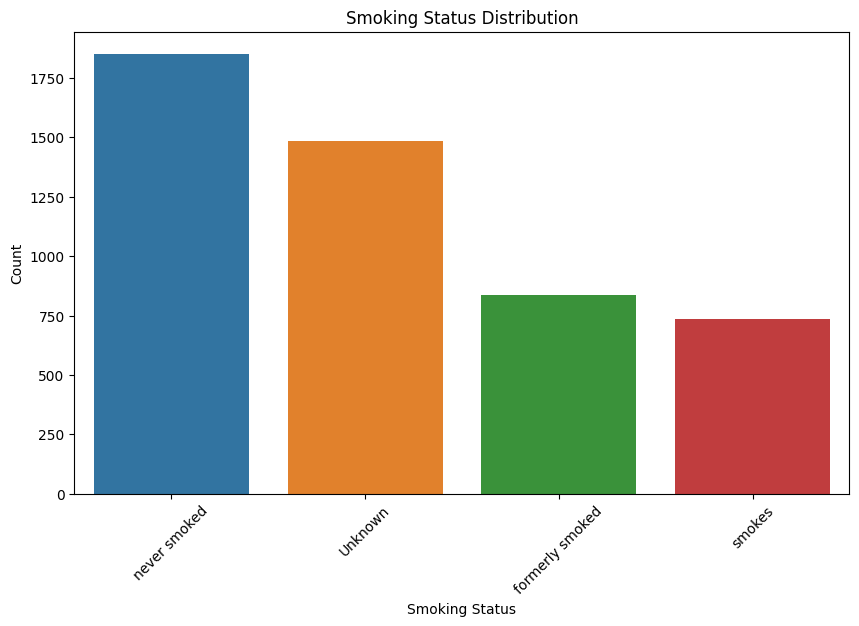

In [0]:
# smoking status distribution
smoking_status_counts = pandas_df['smoking_status'].value_counts().reset_index()
smoking_status_counts.columns = ['smoking_status', 'count']

# Plot smoking status distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='smoking_status', y='count', data=smoking_status_counts)
plt.title('Smoking Status Distribution')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Stroke Distribution

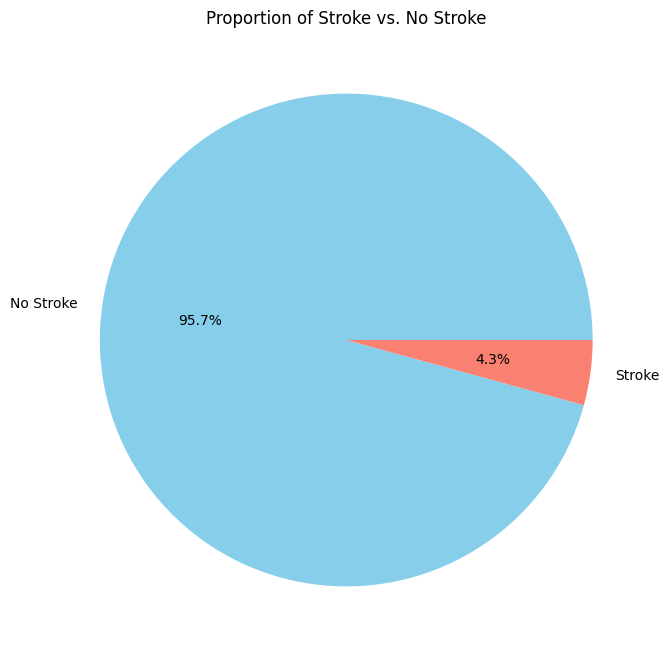

In [0]:

stroke_counts = pandas_df['stroke'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Proportion of Stroke vs. No Stroke')
plt.show()


### Age vs Stroke And BMI Vs Stroke

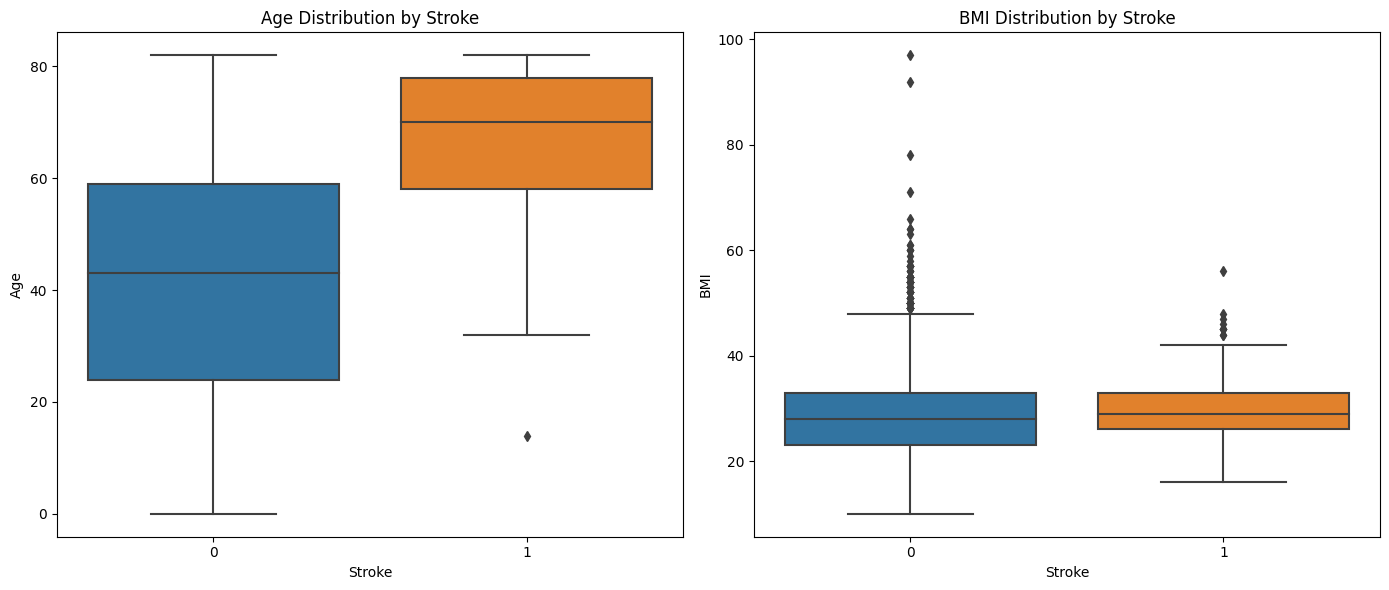

In [0]:


plt.figure(figsize=(14, 6))

# Plot age vs. stroke
plt.subplot(1, 2, 1)
sns.boxplot(x='stroke', y='age', data=pandas_df)
plt.title('Age Distribution by Stroke')
plt.xlabel('Stroke')
plt.ylabel('Age')

# Plot BMI vs. stroke
plt.subplot(1, 2, 2)
sns.boxplot(x='stroke', y='bmi', data=pandas_df)
plt.title('BMI Distribution by Stroke')
plt.xlabel('Stroke')
plt.ylabel('BMI')

plt.tight_layout()

plt.show()

### Correlation Matrix:


/root/.ipykernel/993/command-2022539343420888-3112246427:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = pandas_df.corr()


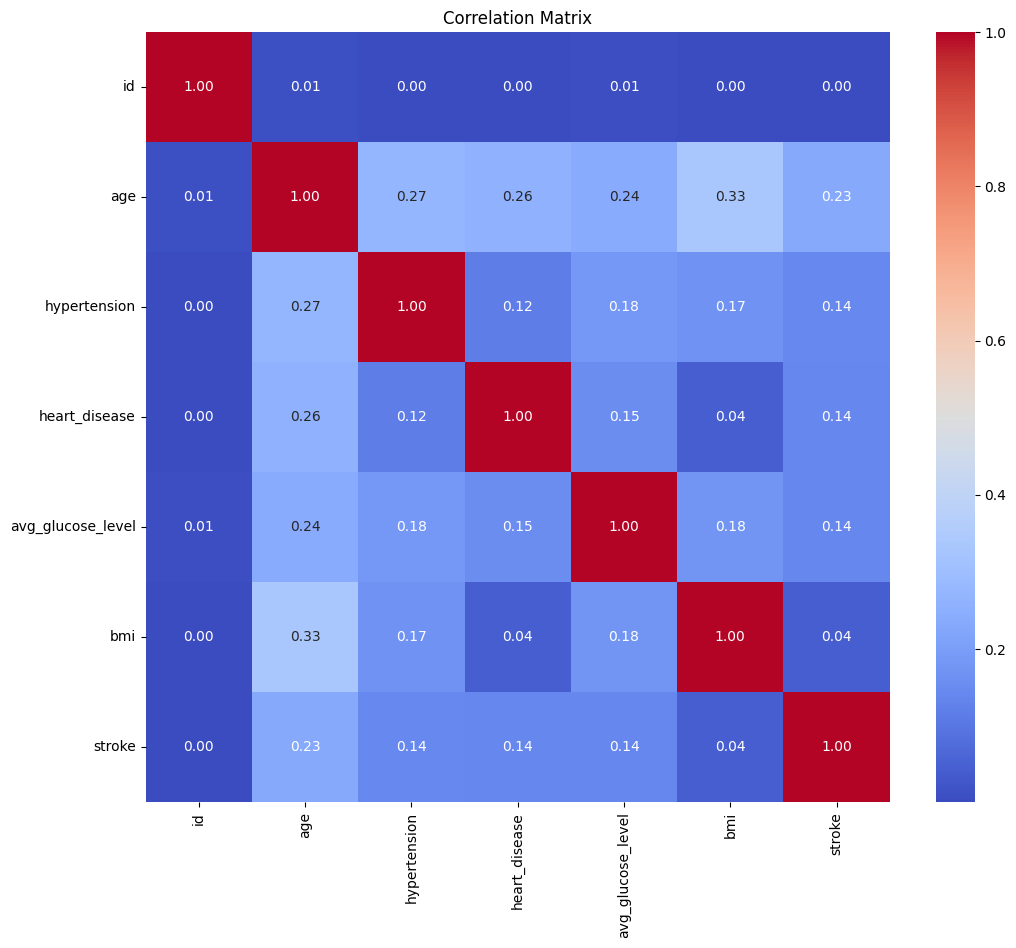

In [0]:
# Calculate correlation matrix
corr = pandas_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()
